# LSTM - vanilla

In [1]:
best_model = "best_model_all_feat_2layers_all_agents_attn.pt"

# best_model = "best_model_all_feat_all_agents.pt"

In [2]:
best_model

'best_model_all_feat_2layers_all_agents_attn.pt'

## Load and prepare data

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [4]:
train_file = np.load('../cse-251-b-2025/train.npz')

train_data = train_file['data']
# train_data = train_data[::3]
print("train_data's shape", train_data.shape)
test_file = np.load('../cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


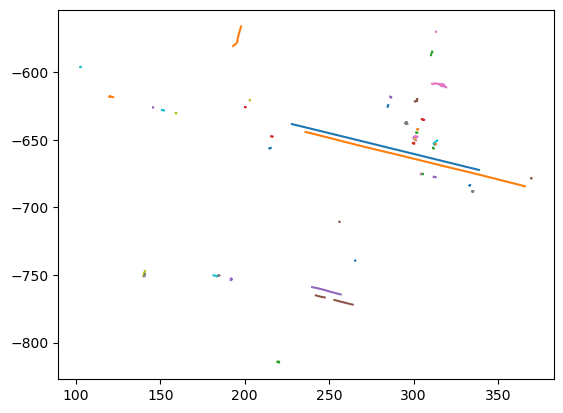

In [5]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [6]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future[..., :2] = future[..., :2] @ R
                future[..., 2:4] = future[..., 2:4] @ R
                # future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future[..., :2] = future[..., :2] - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future[..., :4] = future[..., :4] / self.scale

        # future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
            scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [7]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0 #why not 10

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [23]:
class SpatialAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads=4):
        super().__init__()
        self.query = nn.Linear(input_dim, embed_dim)
        self.key = nn.Linear(input_dim, embed_dim)
        self.value = nn.Linear(input_dim, embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, x):
        # x: [batch_size, time_steps, num_agents, input_dim]
        B, T, N, D = x.shape
        x = x.reshape(B * T, N, D)  # Combine batch and time

        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        out, _ = self.attn(Q, K, V)  # [B*T, N, D]
        return out.reshape(B, T, N, -1).permute(0,2,1,3)  # Restore shape

In [24]:

attention = SpatialAttention(input_dim=6, embed_dim=64, num_heads=4).to(device)
i = 0
for batch in train_dataloader:
    batch = batch.to(device)
    batch_x = batch.x.view(batch.batch_size, 50, 50, 6)
    batch_x = batch_x.permute(0,2,1,3)  # [B, N, T, D]
    attn_output = attention(batch_x)
    i += 1
    if i == 1:
        break


/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_84522/3979743590.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_84522/3979743590.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., 2:4] = future[..., 2:4] @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_84522/3979743590.py:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] - origin


In [12]:
attn_output.shape

torch.Size([32, 50, 50, 64])

In [17]:
class AutoRegressiveLSTM(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=2, num_layers=2, future_steps=60):
        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.future_steps = future_steps

        # Encoder: takes in past trajectory
        #attention
        self.attention = SpatialAttention(input_dim =  self.input_dim, embed_dim= self.hidden_dim, num_heads=4)

        self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Decoder: predicts future positions one step at a time
        self.decoder = nn.LSTM(input_size=5, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, forcing_ratio = 0.5):
    # def forward(self, data):
        x = data.x[..., :5]  # Use position + velocity
        x_ego = x.reshape(-1, 50, 50, self.input_dim)[:, 0, :, :]  # (batch, 50, 5), ego only
        # x = x.reshape(-1, 50, self.input_dim)

        x = x.reshape(-1, 50, 50, self.input_dim)

        x_attn = self.attention(x)  # Apply attention to the input
        batch_size = x.size(0)
        
        if self.training:
            future = data.y.view(batch_size, 60, self.output_dim) # (batch, 60, 2)

        device = x.device

        # Encode past
        _, (hidden, cell) = self.encoder(x)

        # Initialize decoder input with last observed position
        decoder_input = x[:, -1, :self.output_dim].unsqueeze(1)  # (batch, 1, 2)
        
        # print("decoder_input.shape - initial", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = []

        for t in range(self.future_steps):
            output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.out(output)  # (batch, 1, 2)
            outputs.append(pred)

            # TODO: remove forcing ratio?
            if self.training and random.random() < forcing_ratio:
            # if self.training:
                decoder_input = future[:, t].unsqueeze(1)  # ground truth
                # print("decoder_input.shape - teacher forcing", decoder_input.shape)  # should be (batch, 1, 2)
            else:
                decoder_input = pred.detach()  # predicted output as next input
                # print("decoder_input.shape - autoreg", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = torch.cat(outputs, dim=1)  # (batch, 60, 2)
        return outputs

In [18]:
# # Example of basic model with simple attention mechanism
# class SimpleLSTMWithAttn(nn.Module):
#     def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2):
#         super(SimpleLSTMWithAttn, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
#         # Simple attention mechanism
#         self.attention = nn.Linear(hidden_dim, 1)
        
#         # Add multi-layer prediction head for better results
#         self.fc1 = nn.Linear(hidden_dim, hidden_dim)
#         self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
        
#         # Initialize weights properly
#         for name, param in self.named_parameters():
#             if 'weight' in name:
#                 nn.init.xavier_normal_(param)
#             elif 'bias' in name:
#                 nn.init.constant_(param, 0.0)
        
#     def forward(self, data):
#         x = data.x[..., :5]
#         x = x.reshape(-1, 50, 50, 5)  # (batch_size, num_agents, seq_len, input_dim)
#         x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
#         # Process through LSTM
#         lstm_out, _ = self.lstm(x)  # (batch_size, seq_len, hidden_dim)
        
#         # Apply attention mechanism
#         attention_weights = torch.softmax(self.attention(lstm_out), dim=1)  # (batch_size, seq_len, 1)
#         attended_features = torch.sum(lstm_out * attention_weights, dim=1)  # (batch_size, hidden_dim)
        
#         # Process through prediction head
#         features = self.relu(self.fc1(attended_features))
#         features = self.dropout(features)
#         out = self.fc2(features)
        
#         # Reshape to (batch_size, 60, 2)
#         return out.view(-1, 60, 2)

# Train

In [27]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        forcing_ratio = max(0.0, 1.0 - epoch / 50)
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch, forcing_ratio=forcing_ratio)
            y = batch.y.view(batch.num_graphs, 60, 5)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 5)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                # batch.scale turns scale from 7.0 or (1,) shape i.e. scalar to (B,) shape
                # batch.origin turns origin from (1,2) shape to (B,2)
                
                # then .view(-1, 1, 1) turns scale from (B,) to (B, 1, 1)
                # then .unsqueeze(1) turns origin from (B, 2) to (B, 1, 2)
                # because pred and y have shapes (B, 60, 2) so these transformations make them compatible for the calculation
                
                pred_unnorm = pred[...,:2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y[...,:2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [28]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = AutoRegressiveLSTM(input_dim=5, output_dim = 5, hidden_dim=512)
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 8.946
        lr=0.007,  # Lower learning rate
        patience=20,  # More patience
        epochs=150
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 5)
            
            # Unnormalize
            pred = pred[..., :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y[..., :2] * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [29]:
train_and_evaluate_model()

Epoch:   0%|          | 0/200 [00:00<?, ?epoch/s]/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_77665/673074036.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] - origin
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_77665/673074036.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] @ R
Epoch:   0%|          | 0/200 [08:11<?, ?epoch/s]

Epoch 000 | LR 0.006650 | Train MSE 101599.6383 | Val MSE 13183.5758 | Val MAE 652.1830 | Val MSE 645995.2227
Validation improved: inf -> 13183.575775


Epoch:   1%|          | 2/200 [46:40<85:49:15, 1560.38s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 45909.0026 | Val MSE 12731.7138 | Val MAE 722.1488 | Val MSE 623853.9707
Validation improved: 13183.575775 -> 12731.713806


Epoch:   2%|▏         | 3/200 [1:29:58<111:19:44, 2034.44s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 33096.0912 | Val MSE 13569.0201 | Val MAE 572.9189 | Val MSE 664881.9844


Epoch:   2%|▏         | 4/200 [2:18:42<129:52:33, 2385.48s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 23893.0956 | Val MSE 9821.6796 | Val MAE 504.4683 | Val MSE 481262.3086
Validation improved: 12731.713806 -> 9821.679596


Epoch:   2%|▎         | 5/200 [3:11:29<144:29:31, 2667.54s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 17768.4478 | Val MSE 20516.3224 | Val MAE 797.0940 | Val MSE 1005299.7812


Epoch:   3%|▎         | 6/200 [3:52:32<139:59:49, 2597.89s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 15421.2308 | Val MSE 9576.3862 | Val MAE 488.7864 | Val MSE 469242.9248
Validation improved: 9821.679596 -> 9576.386169


Epoch:   4%|▎         | 7/200 [4:52:32<156:50:36, 2925.58s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 13281.9149 | Val MSE 77561.5190 | Val MAE 1360.9954 | Val MSE 3800514.4844


Epoch:   4%|▍         | 8/200 [5:14:20<128:33:55, 2410.60s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 11740.0415 | Val MSE 15824.0450 | Val MAE 660.7334 | Val MSE 775378.2090


Epoch:   4%|▍         | 9/200 [6:02:22<135:42:46, 2557.94s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 10902.0011 | Val MSE 19387.9565 | Val MAE 712.3643 | Val MSE 950009.8711


Epoch:   5%|▌         | 10/200 [6:36:34<126:45:25, 2401.71s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 10009.9170 | Val MSE 14076.5045 | Val MAE 676.9984 | Val MSE 689748.7188


Epoch:   6%|▌         | 11/200 [7:32:40<141:34:59, 2696.82s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 9997.5639 | Val MSE 12164.1658 | Val MAE 570.8118 | Val MSE 596044.1211


Epoch:   6%|▌         | 12/200 [7:45:57<110:39:12, 2118.90s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 8676.5275 | Val MSE 37049.6276 | Val MAE 1006.6403 | Val MSE 1815431.7578


Epoch:   6%|▋         | 13/200 [7:51:59<82:25:19, 1586.74s/epoch] 

Epoch 012 | LR 0.003593 | Train MSE 8414.5772 | Val MSE 11690.8309 | Val MAE 559.3520 | Val MSE 572850.7148


Epoch:   7%|▋         | 14/200 [8:30:27<93:13:53, 1804.48s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 7983.3890 | Val MSE 34584.8360 | Val MAE 1040.4482 | Val MSE 1694656.9883


Epoch:   8%|▊         | 15/200 [8:54:39<87:16:01, 1698.17s/epoch]

Epoch 014 | LR 0.003243 | Train MSE 7645.2480 | Val MSE 9086.7221 | Val MAE 486.4455 | Val MSE 445249.3857
Validation improved: 9576.386169 -> 9086.722076


Epoch:   8%|▊         | 16/200 [9:33:31<96:33:01, 1889.03s/epoch]

Epoch 015 | LR 0.003081 | Train MSE 7400.6779 | Val MSE 16032.6917 | Val MAE 647.8649 | Val MSE 785601.9121


Epoch:   8%|▊         | 17/200 [9:43:31<76:19:12, 1501.38s/epoch]

Epoch 016 | LR 0.002927 | Train MSE 7053.3118 | Val MSE 16938.5577 | Val MAE 649.2918 | Val MSE 829989.3281


Epoch:   9%|▉         | 18/200 [10:00:02<68:09:17, 1348.12s/epoch]

Epoch 017 | LR 0.002781 | Train MSE 6811.5127 | Val MSE 10055.9805 | Val MAE 484.2866 | Val MSE 492743.0420


Epoch:  10%|▉         | 19/200 [10:10:10<56:35:56, 1125.72s/epoch]

Epoch 018 | LR 0.002641 | Train MSE 6550.1073 | Val MSE 15812.0377 | Val MAE 629.5929 | Val MSE 774789.8574


Epoch:  10%|█         | 20/200 [10:20:30<48:41:40, 973.89s/epoch] 

Epoch 019 | LR 0.002509 | Train MSE 6467.1689 | Val MSE 22242.7582 | Val MAE 742.1007 | Val MSE 1089895.1719


Epoch:  10%|█         | 21/200 [10:38:56<50:23:56, 1013.61s/epoch]

Epoch 020 | LR 0.002384 | Train MSE 6558.7782 | Val MSE 14904.4789 | Val MAE 610.6758 | Val MSE 730319.4570


Epoch:  11%|█         | 22/200 [10:52:56<47:32:14, 961.43s/epoch] 

Epoch 021 | LR 0.002265 | Train MSE 6596.4149 | Val MSE 23249.5422 | Val MAE 758.1893 | Val MSE 1139227.5977


Epoch:  12%|█▏        | 23/200 [11:15:37<53:10:21, 1081.48s/epoch]

Epoch 022 | LR 0.002151 | Train MSE 6421.0944 | Val MSE 30165.1314 | Val MAE 899.4417 | Val MSE 1478091.4453


Epoch:  12%|█▏        | 24/200 [11:48:30<65:56:43, 1348.88s/epoch]

Epoch 023 | LR 0.002044 | Train MSE 6249.3977 | Val MSE 12680.2073 | Val MAE 581.3728 | Val MSE 621330.1582


Epoch:  12%|█▎        | 25/200 [12:06:47<61:53:35, 1273.23s/epoch]

Epoch 024 | LR 0.001942 | Train MSE 6294.6207 | Val MSE 20160.6077 | Val MAE 720.7866 | Val MSE 987869.7598


Epoch:  13%|█▎        | 26/200 [12:29:37<62:56:50, 1302.36s/epoch]

Epoch 025 | LR 0.001845 | Train MSE 6340.0740 | Val MSE 11592.2406 | Val MAE 600.2550 | Val MSE 568019.7891


Epoch:  14%|█▎        | 27/200 [12:53:03<64:05:08, 1333.58s/epoch]

Epoch 026 | LR 0.001752 | Train MSE 6776.9280 | Val MSE 24765.8148 | Val MAE 929.1552 | Val MSE 1213524.9336


Epoch:  14%|█▍        | 28/200 [13:21:17<68:52:04, 1441.42s/epoch]

Epoch 027 | LR 0.001665 | Train MSE 6687.8810 | Val MSE 17611.7851 | Val MAE 654.9770 | Val MSE 862977.4707


Epoch:  14%|█▍        | 29/200 [13:49:25<71:59:40, 1515.68s/epoch]

Epoch 028 | LR 0.001582 | Train MSE 6651.1510 | Val MSE 18218.9570 | Val MAE 667.7999 | Val MSE 892728.8906


Epoch:  15%|█▌        | 30/200 [14:08:50<66:35:58, 1410.34s/epoch]

Epoch 029 | LR 0.001502 | Train MSE 7017.9118 | Val MSE 13929.3522 | Val MAE 589.0640 | Val MSE 682538.2500


Epoch:  16%|█▌        | 31/200 [14:52:32<83:16:37, 1773.95s/epoch]

Epoch 030 | LR 0.001427 | Train MSE 7386.5598 | Val MSE 18589.0686 | Val MAE 685.3988 | Val MSE 910864.3535


Epoch:  16%|█▌        | 32/200 [15:22:03<82:44:35, 1773.07s/epoch]

Epoch 031 | LR 0.001356 | Train MSE 7346.8356 | Val MSE 15646.3723 | Val MAE 619.2424 | Val MSE 766672.2578


Epoch:  16%|█▌        | 32/200 [15:37:22<82:01:12, 1757.58s/epoch]


KeyboardInterrupt: 

# Final Pred

In [68]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = AutoRegressiveLSTM(input_dim=5, output_dim = 5, hidden_dim=512).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm[...,:2] * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_5_out.csv', index=True)

In [69]:
output_df.head()

,x,y
index,,
0,5426.052734,1467.540771
1,5426.041992,1467.670532
2,5426.288086,1467.650269
3,5426.220215,1467.730713
4,5426.110352,1467.654907
